# Image Classification and Evaluation

Initial classifier based on the [basic_classification](https://github.com/tensorflow/docs/blob/master/site/en/r1/tutorials/keras/basic_classification.ipynb)

## Import packages

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

Import Tensorflow and the Keras classes needed to construct our model.

In [2]:
import tensorflow as tf
import keras
import numpy as np

print('Tensorfow', tf.__version__)
print('Keras', keras.__version__)
print('Numpy', np.__version__)

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

c:\users\asus\appdata\local\conda\conda\envs\donkey\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Tensorfow 1.8.0
Keras 2.0.8
Numpy 1.14.3


Import other packages.

In [3]:
import os
import matplotlib.pyplot as plt
import time

In [4]:
# Help with Intellisense
%config IPCompleter.greedy=True

## Load data

In [5]:
class_names = ['Left', 'Right', 'Straight']
class_count = len(class_names)

In [6]:
PATH = os.path.join('.', 'data')

The dataset has the following directory structure:
<pre>
<b>data</b>
|__ <b>Training</b>
    |______ <b>Left</b>: [47_cam-image_array_.jpg, 48_cam-image_array_.jpg ...]
    |______ <b>Right</b>: [46_cam-image_array_.jpg, 47_cam-image_array_.jpg ...]
    |______ <b>Straight</b>: [25_cam-image_array_.jpg, 26_cam-image_array_.jpg ...]
|__ <b>Validation</b>
    |______ <b>Left</b>: [2678_cam-image_array_.jpg, 2744_cam-image_array_.jpg ....]
    |______ <b>Right</b>: [2641_cam-image_array_.jpg, 2693_cam-image_array_.jpg ...]
    |______ <b>Straight</b>: [2763_cam-image_array_.jpg, 2806_cam-image_array_.jpg ...]
</pre>

Assign variables with the proper file path for the training and validation set.

In [7]:
train_dir = os.path.join(PATH, 'Training')
validation_dir = os.path.join(PATH, 'Validation')

In [8]:
#Segmented folders
train_left_dir = os.path.join(train_dir, 'left')
train_right_dir = os.path.join(train_dir, 'right')
train_straight_dir = os.path.join(train_dir, 'straight')

validation_left_dir = os.path.join(validation_dir, 'left')
validation_right_dir = os.path.join(validation_dir, 'right')
validation_straight_dir = os.path.join(validation_dir, 'straight')

### Understand the data

Let's look at how many classes are in the training and validation directory:

In [9]:
num_left_tr = len(os.listdir(train_left_dir))
num_right_tr = len(os.listdir(train_right_dir))
num_straight_tr = len(os.listdir(train_straight_dir))

num_left_val = len(os.listdir(validation_left_dir))
num_right_val = len(os.listdir(validation_right_dir))
num_straight_val = len(os.listdir(validation_straight_dir))

total_train = num_left_tr + num_right_tr + num_straight_tr
total_val = num_left_val + num_right_val + num_straight_val

In [10]:
print('total training Left images:', num_left_tr)
print('total training Right images:', num_right_tr)
print('total training Straight images:', num_straight_tr)

print('total validation Left images:', num_left_val)
print('total validation Right images:', num_right_val)
print('total validation Straight images:', num_straight_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training Left images: 702
total training Right images: 719
total training Straight images: 841
total validation Left images: 6
total validation Right images: 7
total validation Straight images: 6
--
Total training images: 2262
Total validation images: 19


For convenience, set up variables to use while pre-processing the dataset and training the network.

In [11]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 120
IMG_WIDTH = 160

verbose = 1
output_path = 'data/'

## Data preparation

Format the images into appropriately pre-processed floating point tensors before feeding to the network:

1. Read images from the disk.
2. Decode contents of these images and convert it into proper grid format as per their RGB content.
3. Convert them into floating point tensors.
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done with the `ImageDataGenerator` class provided by `tf.keras`. It can read images from disk and preprocess them into proper tensors. It will also set up generators that convert these images into batches of tensors—helpful when training the network.

In [12]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

After defining the generators for training and validation images, the `flow_from_directory` method load images from the disk, applies rescaling, and resizes the images into the required dimensions.

In [13]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

Found 2262 images belonging to 3 classes.


In [14]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')

Found 19 images belonging to 3 classes.


### Visualize training images

Visualize the training images by extracting a batch of images from the training generator—which is 32 images in this example—then plot five of them with `matplotlib`.

In [15]:
sample_training_images, _ = next(train_data_gen)

The `next` function returns a batch from the dataset. The return value of `next` function is in form of `(x_train, y_train)` where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.

In [16]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

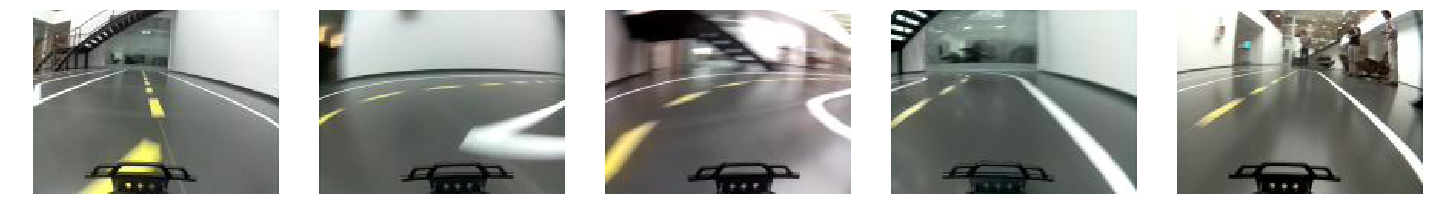

In [17]:
plotImages(sample_training_images[:5])

## Models

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 512 units on top of it that is activated by a `relu` activation function. The model outputs class probabilities based on categorical classification by the `sigmoid` activation function.

## Version 1

In [18]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(class_count, activation='sigmoid')
])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


### Compile the model

For this tutorial, choose the *ADAM* optimizer and *categorical cross entropy* loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [19]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


### Model summary

View all the layers of the network using the model's `summary` method:

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 120, 160, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 80, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 80, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 40, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 20, 64)        0         
__________

### Train the model

Use the `fit_generator` method of the `ImageDataGenerator` class to train the network.

In [21]:
validation_steps = 1 if total_val < batch_size else total_val // batch_size
steps_per_epoch = total_train // batch_size

In [22]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=validation_steps,
    verbose=verbose,
)

Epoch 1/15
17/17 [==============================] - 8s - loss: 1.1200 - acc: 0.3328 - val_loss: 1.0629 - val_acc: 0.3158
Epoch 2/15
17/17 [==============================] - 3s - loss: 0.9031 - acc: 0.3134 - val_loss: 0.8395 - val_acc: 0.4211
Epoch 3/15
17/17 [==============================] - 3s - loss: 0.6906 - acc: 0.3051 - val_loss: 0.6402 - val_acc: 0.4211
Epoch 4/15
17/17 [==============================] - 3s - loss: 0.5894 - acc: 0.3139 - val_loss: 0.5735 - val_acc: 0.4211
Epoch 5/15
17/17 [==============================] - 3s - loss: 0.5472 - acc: 0.3043 - val_loss: 0.5365 - val_acc: 0.4211
Epoch 6/15
17/17 [==============================] - 3s - loss: 0.5196 - acc: 0.3098 - val_loss: 0.5213 - val_acc: 0.4211
Epoch 7/15
17/17 [==============================] - 3s - loss: 0.5100 - acc: 0.3078 - val_loss: 0.5201 - val_acc: 0.3684
Epoch 8/15
17/17 [==============================] - 3s - loss: 0.5019 - acc: 0.3185 - val_loss: 0.4953 - val_acc: 0.3684
Epoch 9/15
17/17 [==============

### Visualize training results

Visualize the model after training. The accuracy should go up after training the model for more epochs.

In [23]:
def visualize_model(history):
    current_time = time.time() * 1000
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
        
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')
    plt.show()
    
    #plt.savefig('train_loss_{}.png'.format(current_time))

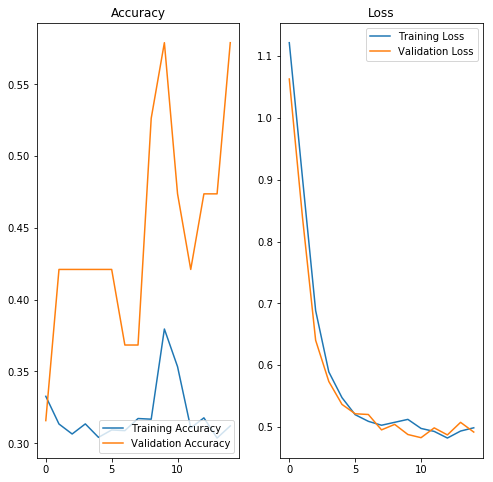

In [24]:
visualize_model(history)

In [25]:
def bench(history):
    print("Train accuracy %.2f%% (+/- %.2f%%)" % (np.mean(history.history['acc']), np.std(np.mean(history.history['acc']))) )
    print("Test  accuracy %.2f%% (+/- %.2f%%)" % (np.mean(history.history['val_acc']), np.std(np.mean(history.history['val_acc']))) )
    print("Train loss     %.2f%% (+/- %.2f%%)" % (np.mean(history.history['loss']), np.std(np.mean(history.history['loss']))) )
    print("Test  loss     %.2f%% (+/- %.2f%%)" % (np.mean(history.history['val_loss']), np.std(np.mean(history.history['val_loss']))) )

bench(history)    

Train accuracy 0.32% (+/- 0.00%)
Test  accuracy 0.45% (+/- 0.00%)
Train loss     0.59% (+/- 0.00%)
Test  loss     0.58% (+/- 0.00%)


### Predictions

In [26]:
sample_val_images, sample_val_labels = next(val_data_gen)
predictions = model.predict(sample_val_images)

In [27]:
print('Predictions:', predictions[0], 'Labels:', sample_val_labels[0], 'Result:', np.argmax(predictions[0]))
print('Predictions:', predictions[1], 'Labels:', sample_val_labels[1], 'Result:', np.argmax(predictions[1]))

Predictions: [9.9999547e-01 6.0198968e-04 6.7654362e-08] Labels: [1. 0. 0.] Result: 0
Predictions: [9.9999869e-01 1.4837703e-05 2.1810955e-04] Labels: [1. 0. 0.] Result: 0


In [28]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)
  
  predicted_label = np.argmax(predictions_array)
  real_label = int(np.argmax(true_label))
  score = 100*np.max(predictions_array)
  #print('predicted_label', predicted_label, 'true_label', true_label, 'predictions_array', predictions_array, 'score', score, 'real_label', real_label)
  if true_label[predicted_label] == 1.: # Match!
    color = 'green'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                score,
                                class_names[real_label]),
                                color=color)

In [29]:
def plot_value_array(i, predictions_array, true_label, class_names):

  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  #plt.ylabel('Score')
  plt.xlabel(' - '.join(map(str, class_names)))
  plt.title('Scores by class')
  plt.legend()

  #print('predictions_array', predictions_array, len(class_names))
  thisplot = plt.bar(range(len(class_names)), predictions_array, label=class_names)
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

In [30]:
def predictions_array(predictions, sample_val_labels, sample_val_images, class_names):
    # Plot the first X test images, their predicted label, and the true label
    # Color correct predictions in blue, incorrect predictions in red
    num_rows = 1
    num_cols = 4
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(num_images):
      plt.subplot(num_rows, 2*num_cols, 2*i+1)
      plot_image(i, predictions[i], sample_val_labels, sample_val_images)
      plt.subplot(num_rows, 2*num_cols, 2*i+2)
      plot_value_array(i, predictions[i], sample_val_labels, class_names)
    plt.show() 

c:\users\asus\appdata\local\conda\conda\envs\donkey\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


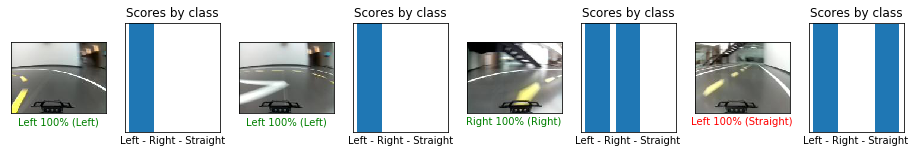

In [31]:
predictions_array(predictions, sample_val_labels, sample_val_images, class_names)

## Version 2
Use a similar CNN from [robocars repository](https://github.com/autorope/donkeycar/blob/dev/donkeycar/parts/keras.py), change the output to be a classifier.

In [32]:
def default_categorical():
    from keras.layers import Input, Dense, merge
    from keras.models import Model
    from keras.layers import Convolution2D, MaxPooling2D, Reshape, BatchNormalization
    from keras.layers import Activation, Dropout, Flatten, Dense, Cropping2D
    from keras.layers import Lambda, Conv2D
    
    drop = 0.2
    default_shape = (120, 160, 3)
    img_in = Input(shape=default_shape, name='img_in')                      # First layer, input layer, Shape comes from camera.py resolution, RGB
    x = img_in

    x = Convolution2D(24, (5,5), strides=(2,2), activation='relu')(x)       # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
    x = Dropout(drop)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
    x = Convolution2D(32, (5,5), strides=(2,2), activation='relu')(x)       # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
    x = Dropout(drop)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
    x = Convolution2D(64, (5,5), strides=(2,2), activation='relu')(x)       # 64 features, 5px5p kernal window, 2wx2h stride, relu
    x = Convolution2D(64, (3,3), strides=(2,2), activation='relu')(x)       # 64 features, 3px3p kernal window, 2wx2h stride, relu
    x = Dropout(drop)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
    x = Convolution2D(64, (3,3), strides=(1,1), activation='relu')(x)       # 64 features, 3px3p kernal window, 1wx1h stride, relu
    x = Dropout(drop)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
    # Possibly add MaxPooling (will make it less sensitive to position in image).  Camera angle fixed, so may not to be needed

    x = Flatten(name='flattened')(x)                                        # Flatten to 1D (Fully connected)
    x = Dense(100, activation='relu')(x)                                    # Classify the data into 100 features, make all negatives 0
    x = Dropout(drop)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
    x = Dense(50, activation='relu')(x)                                     # Classify the data into 50 features, make all negatives 0
    x = Dropout(drop)(x)                                                      # Randomly drop out 10% of the neurons (Prevent overfitting)
    #Class output
    class_out = Dense(class_count, activation='softmax', name='class_out')(x)        # 3 categories and find best one based off percentage 0.0-1.0
    
    model = Model(inputs=[img_in], outputs=[class_out])
    model.compile(optimizer='adam',
                  loss={'class_out': 'categorical_crossentropy'},
                  loss_weights={'class_out': 0.1},
                  metrics=['accuracy'])
    return model

In [33]:
model = default_categorical()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, 120, 160, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 58, 78, 24)        1824      
_________________________________________________________________
dropout_3 (Dropout)          (None, 58, 78, 24)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 27, 37, 32)        19232     
_________________________________________________________________
dropout_4 (Dropout)          (None, 27, 37, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 17, 64)        51264     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 8, 64)          36928     
__________

In [34]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_data_gen,
    verbose=verbose,
    validation_steps=validation_steps
)

Epoch 1/15
17/17 [==============================] - 3s - loss: 0.1090 - acc: 0.3859 - val_loss: 0.1065 - val_acc: 0.6316
Epoch 2/15
17/17 [==============================] - 2s - loss: 0.0971 - acc: 0.4858 - val_loss: 0.0594 - val_acc: 0.7895
Epoch 3/15
17/17 [==============================] - 2s - loss: 0.0561 - acc: 0.7795 - val_loss: 0.0298 - val_acc: 0.8947
Epoch 4/15
17/17 [==============================] - 2s - loss: 0.0323 - acc: 0.8848 - val_loss: 0.0076 - val_acc: 1.0000
Epoch 5/15
17/17 [==============================] - 2s - loss: 0.0176 - acc: 0.9373 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 6/15
17/17 [==============================] - 2s - loss: 0.0159 - acc: 0.9451 - val_loss: 0.0055 - val_acc: 1.0000
Epoch 7/15
17/17 [==============================] - 2s - loss: 0.0115 - acc: 0.9600 - val_loss: 0.0055 - val_acc: 0.9474
Epoch 8/15
17/17 [==============================] - 2s - loss: 0.0074 - acc: 0.9775 - val_loss: 4.1372e-04 - val_acc: 1.0000
Epoch 9/15
17/17 [==========

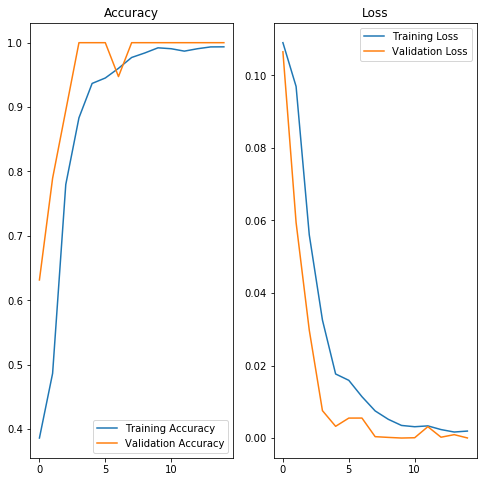

In [35]:
visualize_model(history)

c:\users\asus\appdata\local\conda\conda\envs\donkey\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


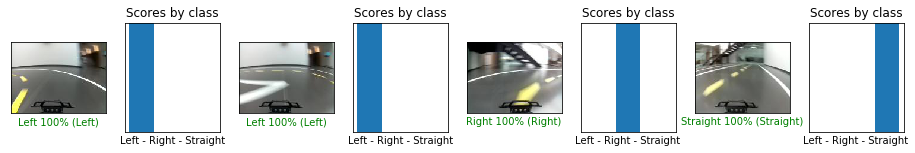

In [36]:
predictions = model.predict(sample_val_images)
predictions_array(predictions, sample_val_labels, sample_val_images, class_names)

In [37]:
bench(history)

Train accuracy 0.89% (+/- 0.00%)
Test  accuracy 0.95% (+/- 0.00%)
Train loss     0.02% (+/- 0.00%)
Test  loss     0.01% (+/- 0.00%)


## Version 3
Tweak the model, changes applied
 * Reduce the capacity of the network
 * Add weight regularization.
 * Add dropout

The objective is to prevent overfitting in the CNN.

Pending:
 * Get more training data
 * data-augmentation (for example use horizontal flip)
 
Ideas taken from [Overfit and Underfit](https://github.com/tensorflow/docs/blob/master/site/en/r1/tutorials/keras/overfit_and_underfit.ipynb)

In [38]:
def default_categorical_crop():
    from keras.layers import Input, Dense, merge
    from keras.models import Model
    from keras.layers import Convolution2D, MaxPooling2D, Reshape, BatchNormalization
    from keras.layers import Activation, Dropout, Flatten, Dense, Cropping2D
    from keras.layers import Lambda, Conv2D
    
    drop = 0.3 # Tested with 0.1, 0.2, 0.3, 0.4
    default_shape = (120, 160, 3)
    img_in = Input(shape=default_shape, name='img_in')
    x = img_in
    x = Cropping2D(cropping=((40,0), (0,0)))(x) #trim pixels off top Added

    x = BatchNormalization(input_shape=default_shape)(x) ## added (https://stackoverflow.com/questions/41847376/keras-model-to-json-error-rawunicodeescape-codec-cant-decode-bytes-in-posi) https://github.com/autorope/notebooks/blob/master/notebooks/train%20on%20all%20data.ipynb
    x = Convolution2D(24, (5,5), strides=(2,2), activation='relu')(x)
    x = Dropout(drop)(x)
    x = Convolution2D(32, (5,5), strides=(2,2), activation='relu')(x)
    x = Dropout(drop)(x)
    x = Convolution2D(64, (5,5), strides=(2,2), activation='relu')(x)
    x = Convolution2D(64, (3,3), strides=(2,2), activation='relu')(x)
    x = Dropout(drop)(x)
    x = Convolution2D(64, (3,3), strides=(1,1), activation='relu')(x)
    x = Dropout(drop)(x)
    
    x = Flatten(name='flattened')(x)
    x = Dense(100, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu')(x)                                    # Classify the data into 100 features, make all negatives 0
    x = Dropout(drop)(x)
    x = Dense(50, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu')(x)                                     # Classify the data into 50 features, make all negatives 0
    x = Dropout(drop)(x)

    #Class output
    class_out = Dense(class_count, activation='softmax', name='class_out')(x)
    
    model = Model(inputs=[img_in], outputs=[class_out])
    model.compile(optimizer='adam',
                  loss={'class_out': 'categorical_crossentropy'},
                  loss_weights={'class_out': 0.1},
                  metrics=['accuracy'])
    return model

In [39]:
model = default_categorical_crop()

In [40]:
# New changes
steps = 100
epochs = 100
min_delta = .0005
patience = 7 # 5
monitor='val_loss'

saved_model_path = './models/version03_1.h5'

#checkpoint to save model after each epoch
save_best = keras.callbacks.ModelCheckpoint(saved_model_path, 
                                            monitor=monitor, 
                                            verbose=verbose, 
                                            save_best_only=True, 
                                            mode='min')

#stop training if the validation error stops improving.
early_stop = keras.callbacks.EarlyStopping(monitor=monitor, 
                                           min_delta=min_delta, 
                                           patience=patience, 
                                           verbose=verbose, 
                                           mode='auto')

callbacks_list = [save_best, early_stop]

In [41]:
history = model.fit_generator(
    train_data_gen,
    epochs=epochs,
    steps_per_epoch=steps,
    validation_data=val_data_gen,
    validation_steps=validation_steps,
    verbose=verbose,
    callbacks=callbacks_list
)

Epoch 1/100
100/100 [==============================] - 12s - loss: 0.1662 - acc: 0.7479 - val_loss: 0.1217 - val_acc: 0.8421
Epoch 2/100
100/100 [==============================] - 10s - loss: 0.0465 - acc: 0.9694 - val_loss: 0.0501 - val_acc: 0.8421
Epoch 3/100
100/100 [==============================] - 10s - loss: 0.0207 - acc: 0.9846 - val_loss: 0.0160 - val_acc: 1.0000
Epoch 4/100
100/100 [==============================] - 10s - loss: 0.0113 - acc: 0.9916 - val_loss: 0.0085 - val_acc: 1.0000
Epoch 5/100
100/100 [==============================] - 11s - loss: 0.0072 - acc: 0.9934 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 6/100
100/100 [==============================] - 11s - loss: 0.0052 - acc: 0.9947 - val_loss: 0.0067 - val_acc: 1.0000
Epoch 7/100
100/100 [==============================] - 11s - loss: 0.0041 - acc: 0.9952 - val_loss: 0.0090 - val_acc: 0.9474
Epoch 8/100
100/100 [==============================] - 11s - loss: 0.0032 - acc: 0.9963 - val_loss: 0.0017 - val_acc: 1.0000


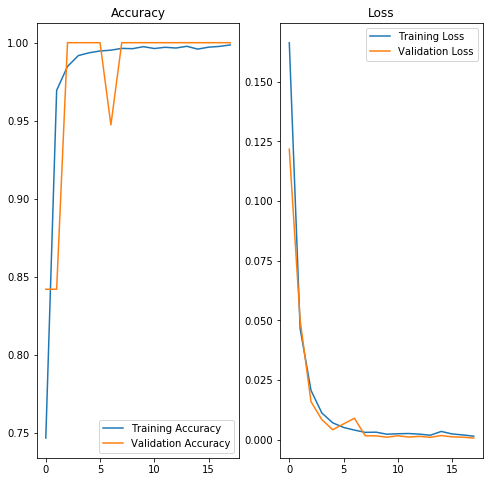

In [42]:
visualize_model(history)

In [43]:
bench(history)

Train accuracy 0.98% (+/- 0.00%)
Test  accuracy 0.98% (+/- 0.00%)
Train loss     0.02% (+/- 0.00%)
Test  loss     0.01% (+/- 0.00%)


In [44]:
predictions = model.predict(sample_val_images)

c:\users\asus\appdata\local\conda\conda\envs\donkey\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


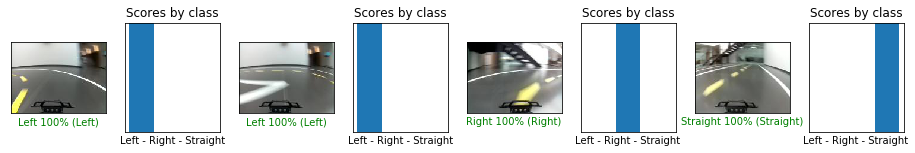

In [45]:
predictions_array(predictions, sample_val_labels, sample_val_images, class_names)

## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set. In our case we created a video to check how the whole pipeline works.

In [46]:
# Dataset Parameters
saved_model_path = './models/version03_1.h5'
checkpoint_dir = './models/'

model = default_categorical_crop()
model.load_weights(saved_model_path)
img_arr = sample_val_images[0].reshape((1,) + sample_val_images[0].shape)
#loss,acc = model.predict(sample_val_labels, sample_val_images, verbose=2)

prediction = model.predict(img_arr)
prediction_index = np.argmax(prediction)
class_prediction = class_names[prediction_index]
prediction_score = int(np.max(prediction)*100)
print("{} Score {}%".format(class_prediction, prediction_score))

#latest = tf.train.latest_checkpoint(checkpoint_dir)
#model.load_weights(latest)
#predictions_array(class_result, sample_val_labels[0], sample_val_images[0], class_names)

Left Score 99%


## Sample Video
Final Result: test the pipeline with sample videos.

In [47]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2

opencv_version = cv2.__version__.split(".")[0] # get major version
if opencv_version == '3':
  opencv_line = cv2.LINE_AA
else:
  opencv_line = cv2.CV_AA

font = cv2.FONT_HERSHEY_SIMPLEX

In [48]:
def add_label_to_image(img, text):
    '''Add a label to the image'''
    x_centroid, y_centroid = 5, IMG_HEIGHT - 20
    cv2.putText(img,str(text),(x_centroid,y_centroid), font, 0.5, (0,0,0), 1, opencv_line)
    return img

In [49]:
def BGR_to_RGB(img):
    '''Conversion from https://gist.github.com/walkoncross/9e2074a0efc2710302be49ec668b5249'''
    return img[...,::-1]

def RGB_to_BGR(img):
    '''Conversion from https://gist.github.com/walkoncross/9e2074a0efc2710302be49ec668b5249'''
    return img[...,::-1]


In [50]:
def process_class(prediction):
    '''Return Label for prediction'''
    
    prediction_index = np.argmax(prediction)
    class_prediction = class_names[prediction_index]
    prediction_score = int(np.max(prediction)*100)
    classification = "{} {}%".format(class_prediction, prediction_score)
    
    return classification

In [51]:
def process_pipeline(img):
    '''Inject here pipeline detail'''
    
    #image = BGR_to_RGB(img)
    #image = RGB_to_BGR(img)
    image = img
    
    img_arr = image.reshape((1,) + image.shape)
    
    prediction = model.predict(img_arr)
    classification_text = process_class(prediction)
    
    #print(classification_text, prediction)
    add_label_to_image(img, classification_text)
    
    return image

In [52]:
def process_image(image):
    '''Pipeline to process the image'''
    # NOTE: The output should be a color image (3 channel) for processing video below
    result = process_pipeline(image)
    return result

In [53]:
def generate_video(output_path, file_name, output_file_name):
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    video_input = output_path + file_name
    video_output = output_path + output_file_name

    clip1 = VideoFileClip(video_input).subclip(0,20)
    #clip1 = VideoFileClip(video_input)
    white_clip = clip1.fl_image(process_image)
    %time white_clip.write_videofile(video_output, audio=False)
    clip1.reader.close()

In [54]:
video_input = 'tub_1_18-05-25.mp4'
video_output = 'tub_1_18-05-25_output.mp4'
generate_video(output_path, video_input, video_output)

[MoviePy] >>>> Building video data/tub_1_18-05-25_output.mp4
[MoviePy] Writing video data/tub_1_18-05-25_output.mp4


100%|██████████████████████████████████████████████████████████████████████████████▊| 400/401 [00:01<00:00, 281.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: data/tub_1_18-05-25_output.mp4 

Wall time: 1.63 s


Play the videos inline

In [55]:
HTML("""
<video width="160" height="120" controls>
  <source src="{0}">
</video>
""".format(output_path + video_output))

In [56]:
video_input = 'simulator_sandbox01.mp4'
video_output = 'simulator_sandbox01_output.mp4'
generate_video(output_path, video_input, video_output)

[MoviePy] >>>> Building video data/simulator_sandbox01_output.mp4
[MoviePy] Writing video data/simulator_sandbox01_output.mp4


100%|██████████████████████████████████████████████████████████████████████████████▊| 400/401 [00:01<00:00, 284.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: data/simulator_sandbox01_output.mp4 

Wall time: 1.52 s


In [57]:
HTML("""
<video width="160" height="120" controls>
  <source src="{0}">
</video>
""".format(output_path + video_output))